The curve of GLV equation at once

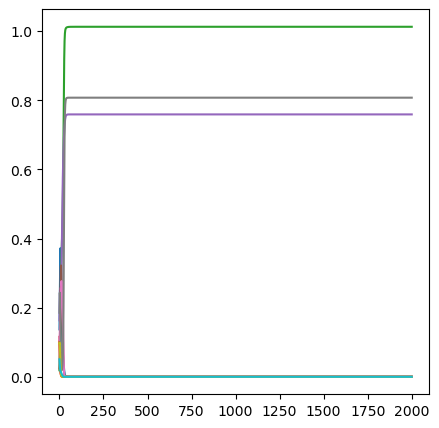

In [304]:
import scipy
import numpy as np,matplotlib.pyplot as plt

#basic equations definition
def equations(t,y,Sigma,NumSpecies,speed,effection,dilution):
    eq=[]
    for i in list(range(NumSpecies)):
        temp=effection[:,i]*y
        PosSum=np.sum(temp[temp>0])
        NegSum=np.sum(temp[temp<0])
        eq.append(speed[i]*y[i]*(1+NegSum+Sigma[i]*PosSum/(1+PosSum))-dilution*y[i])
    return eq

#GLV equations simulation
def GLV(timespan,initial,Sigma,NumSpecies,speed,effection,dilution):
    sol=scipy.integrate.solve_ivp(equations,
                                  t_span=timespan,
                                  y0=initial,
                                  method='RK45',
                                  args=(Sigma,NumSpecies,speed,effection,dilution),
                                  dense_output=True)
    
    return sol

#try different parameters to find the best range
NumSpecies=10
timespan=[0,2000]

initialtemp=np.random.rand(NumSpecies)
initial=initialtemp/np.sum(initialtemp)

Sigma=0.5*np.random.rand(NumSpecies)
m0=0.3+0.5*np.random.rand()
w0=0.4*np.random.rand()
speed=m0+w0*np.random.rand(NumSpecies)
m1=0.4+1.3*(1-np.random.rand()**3)
w1=0.4*np.random.rand()
temp=np.random.rand()
matrix=(-1)**(np.random.rand(NumSpecies,NumSpecies)<(1-temp**2)).astype('float')
matrix[matrix==1]=matrix[matrix==1]/np.random.randint(low=2,high=5,size=matrix[matrix==1].shape)
effection=matrix*(m1-w1+2*w1*np.random.rand(NumSpecies,NumSpecies))*(np.random.rand(NumSpecies,NumSpecies)<(1-temp**2))
for same in list(range(NumSpecies)):effection[same,same]=-1
dilution=0.1+0.1*np.random.rand()
plt.figure(figsize=(5,5))

abundance=GLV(timespan,initial,Sigma,NumSpecies,speed,effection,dilution).sol(np.linspace(0,timespan[1],timespan[1])).T
#print('initial:',initial,'\nspeed:',speed,'\neffection:',effection,'\ndilution:',dilution)
plt.plot(np.linspace(0,timespan[1],timespan[1]),abundance)

Generate the dataset

In [310]:
import scipy,time
import numpy as np,pandas as pd,matplotlib.pyplot as plt
from numpy.random import rand as rd

def equations(t,y,NumSpecies,growth_rate,Sigma,interaction,dilution):
    eq=[]
    for i in range(NumSpecies):
        temp=interaction[:,i]*y
        PosSum=np.sum(temp[temp>0])
        NegSum=np.sum(temp[temp<0])
        eq.append(growth_rate[i]*y[i]*(1+NegSum+Sigma[i]*PosSum/(1+PosSum))-dilution*y[i])
    return eq

def GLV(timespan,initial,NumSpecies,growth_rate,Sigma,interaction,dilution):
    sol=scipy.integrate.solve_ivp(equations,
                                  t_span=timespan,
                                  y0=initial,
                                  method='RK45',
                                  args=(NumSpecies,growth_rate,Sigma,interaction,dilution),
                                  dense_output=True)
    return sol.sol(timespan[1])

def euler(result,threshold):
    for x in range(result.size):
        result['percentage'][x]=tuple(result['percentage'][x])
        for y in range(x,result.size):
            if np.sqrt(np.sum(np.square(np.array(result['percentage'][x])-np.array(result['percentage'][y]))))<threshold:
                result['percentage'][y]=tuple(result['percentage'][x])
            else:
                result['percentage'][y]=tuple(result['percentage'][y])
    return result.drop_duplicates(subset=['percentage']).size,result.value_counts().tolist()/np.sum(result.value_counts().tolist())

def func(NumSpecies,timespan,reapt,threshold,showindex):
    start_time=time.time()
    result=pd.DataFrame(columns=['parameters','condition','percentage'])
    for i in range(reapt[0]):
        Sigma=0.5*rd(NumSpecies)
        growth_rate=0.3+0.5*rd()+0.4*rd()*rd(NumSpecies)
        tempt=(-1)**(rd(NumSpecies,NumSpecies)<(1-0.2*rd()**2)).astype('float')
        tempt[tempt==1]=tempt[tempt==1]/np.random.randint(low=2,high=5,size=tempt[tempt==1].shape)
        interaction=tempt*(0.4+1.3*(1-rd()**3)-0.4*rd()+2*0.4*rd()*rd(NumSpecies,NumSpecies))*(rd(NumSpecies,NumSpecies)<(1-0.2*rd()**2))
        for index in range(NumSpecies):interaction[index,index]=-1
        dilution=0.1+0.1*rd()
        if i%showindex==0:print(i,'th Loop cumcost:',int((time.time()-start_time)/60),'minutes')
        loop=pd.DataFrame(columns=['percentage'])
        for j in range(reapt[1]):
            initialtemp=rd(NumSpecies)
            initial=initialtemp/np.sum(initialtemp)
            loop.at[j,'percentage']=GLV(timespan,initial,NumSpecies,growth_rate,Sigma,interaction,dilution)
            
        result.at[i,'parameters']=np.concatenate((growth_rate,
                                                  Sigma,
                                                  interaction[~np.eye(interaction.shape[0],dtype=bool)].reshape(-1),
                                                  dilution),axis=None)
        result.at[i,'condition'],result.at[i,'percentage']=euler(loop,threshold)
    #result.to_excel('NumSpecies{a}reapt{b}.xlsx'.format(a=NumSpecies,b=reapt[0]*reapt[1]))
    return result

Generate dataset by multiple CPU cores

In [35]:
import multiprocessing 
if __name__=='__main__':
    NumSpecies=10
    timespan=[0,1500]
    reapt=[1,10]
    threshold=0.1
    showindex=10
    n_cores =multiprocessing.cpu_count()
    
    # Create list of parameter sets
    parameters = []
    for i in range(n_cores):
        parameters.append((NumSpecies,timespan,reapt,threshold,showindex))
    
    # Create processes
    processes = []
    for params in parameters:
        process = multiprocessing.Process(target=func, args=params)
        process.start()
        processes.append(process)
    
    # Join processes and collect results
    process_results = []
    for process in processes:
        process.join()
        process_results.append(func(*params))
    
    # Concatenate all DataFrames
    final_df = pd.concat(process_results).reset_index(drop=True)
    

0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes
0 th Loop cumcost: 0 minutes


Scan the final results

In [36]:
final_df

,parameters,condition,percentage
0,"[0.35910174413467594, 0.3588790963110707, 0.36...",1,[1.0]
1,"[0.40760265039893334, 0.433736307572962, 0.388...",3,"[0.4, 0.3, 0.3]"
2,"[0.9014429174368691, 0.6795643120377396, 0.916...",2,"[0.9, 0.1]"
3,"[0.9893231654699162, 1.0059379759265532, 0.800...",2,"[0.7, 0.3]"
4,"[0.7942954100388313, 0.780288836195435, 0.7647...",1,[1.0]
5,"[0.5698354398580108, 0.7812064139556694, 0.766...",3,"[0.5, 0.3, 0.2]"
6,"[0.4539298572035051, 0.6229469297484245, 0.769...",2,"[0.9, 0.1]"
7,"[0.4998463422083447, 0.5303127384237747, 0.603...",1,[1.0]
8,"[0.7593138970993404, 0.7464524867232577, 0.733...",1,[1.0]
9,"[0.6891985367216762, 0.7356908795003999, 0.687...",1,[1.0]


Compare with normal codes

In [315]:
result=func(NumSpecies=10,timespan=[0,1500],reapt=[1,10],threshold=0.1,showindex=100)
display(result)

0 th Loop cumcost: 0 minutes


,parameters,condition,percentage
0,"[0.4174653231848831, 0.42809799917380525, 0.51...",2,"[0.7, 0.3]"


Choose the right threshold

In [1]:
import scipy,time
import numpy as np,pandas as pd,matplotlib.pyplot as plt
from numpy.random import rand as rd

def equations(t,y,NumSpecies,growth_rate,Sigma,interaction,dilution):
    eq=[]
    for i in range(NumSpecies):
        temp=interaction[:,i]*y
        PosSum=np.sum(temp[temp>0])
        NegSum=np.sum(temp[temp<0])
        eq.append(growth_rate[i]*y[i]*(1+NegSum+Sigma[i]*PosSum/(1+PosSum))-dilution*y[i])
    return eq

def GLV(timespan,initial,NumSpecies,growth_rate,Sigma,interaction,dilution):
    sol=scipy.integrate.solve_ivp(equations,
                                  t_span=timespan,
                                  y0=initial,
                                  method='RK45',
                                  args=(NumSpecies,growth_rate,Sigma,interaction,dilution),
                                  dense_output=True)
    return sol.sol(timespan[1])

def euler(result,threshold):
    for x in range(result.size):
        result['percentage'][x]=tuple(result['percentage'][x])
        for y in range(x,result.size):
            if np.sqrt(np.sum(np.square(np.array(result['percentage'][x])-np.array(result['percentage'][y]))))<threshold:
                result['percentage'][y]=tuple(result['percentage'][x])
            else:
                result['percentage'][y]=tuple(result['percentage'][y])
    return result.drop_duplicates(subset=['percentage']).size,result.value_counts().tolist()/np.sum(result.value_counts().tolist())

def func(NumSpecies,timespan,reapt,threshold,showindex):
    start_time=time.time()

    Sigma=0.5*rd(NumSpecies)
    growth_rate=0.3+0.5*rd()+0.4*rd()*rd(NumSpecies)
    tempt=(-1)**(rd(NumSpecies,NumSpecies)<(1-0.2*rd()**2)).astype('float')
    tempt[tempt==1]=tempt[tempt==1]/np.random.randint(low=2,high=5,size=tempt[tempt==1].shape)
    interaction=tempt*(0.4+1.3*(1-rd()**3)-0.4*rd()+2*0.4*rd()*rd(NumSpecies,NumSpecies))*(rd(NumSpecies,NumSpecies)<(1-0.2*rd()**2))
    for index in range(NumSpecies):interaction[index,index]=-1
    dilution=0.1+0.1*rd()
    loop=pd.DataFrame(columns=['percentage'])
    for j in range(reapt[1]):
        initialtemp=rd(NumSpecies)
        initial=initialtemp/np.sum(initialtemp)
        loop.at[j,'percentage']=GLV(timespan,initial,NumSpecies,growth_rate,Sigma,interaction,dilution)
    return loop

loop=func(NumSpecies=10,timespan=[0,1500],reapt=[0,10000],threshold=0.1,showindex=10)

distance=[]
for i in range(loop.size):
    #loop['percentage'][i]=tuple(loop['percentage'][i])
    for j in range(i+1,loop.size):
        distance.append(np.round(np.sqrt(np.sum(np.square(np.array(loop['percentage'][i])-np.array(loop['percentage'][j])))),decimals=5))
my_count = pd.Series(distance).value_counts()
display(my_count)

0.0    49995000
dtype: int64

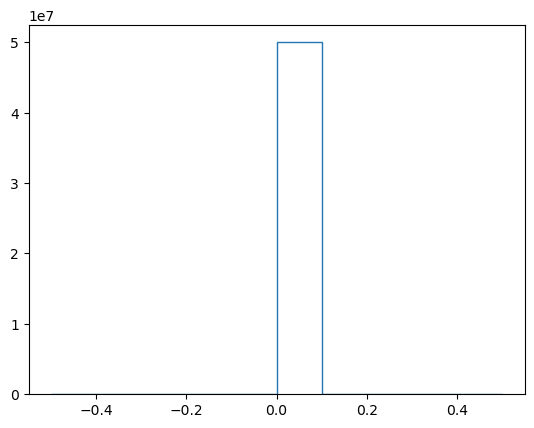

In [2]:
counts, bins = np.histogram(distance)
plt.stairs(counts, bins)

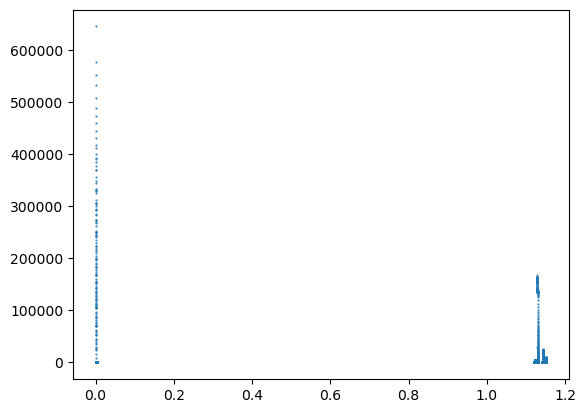

In [6]:
plt.plot(my_count.index,my_count.values,'.',markersize=1)
plt.show()